## Imports

#### **You will need to install the "haversine" and "cartopy" modules first. I recommend conda-forge

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dts
import pandas as pd
import os
import cartopy.crs as ccrs
import itertools as it
from haversine import haversine
from operator import attrgetter
from matplotlib.lines import Line2D
from datetime import datetime, timedelta
from glob import glob

# imports from this repository
import helpers
from station import Station

## Download CWS data from Synoptic (MesoWest)

In [7]:
stations_file = './data/20191216.json' #filename for the download output. name this whatever you want, plus .json
api_token = '###############' #API token from your Synoptic account
lat = 34.582253 
lon = -86.927738
radius = 75 #range in km, from the lat/lon coordinates provided, in which to search for stations
max_stations = 100 #max number of stations to download
start_datetime = 201912160600 #date and time for start of the data
end_datetime = 201912170600

if not os.path.exists(stations_file):
    print('Starting download ...')
    Station.download(stations_file, api_token, lat, lon, radius, max_stations, start_datetime, end_datetime)
else:
    print('File already exists. Cancelling download ...')

File already exists. Cancelling download ...


## Loading the data file

In [8]:
st = Station.loadJSON(stations_file)

## Plotting

#### Plot all station locations and their MNET ID's

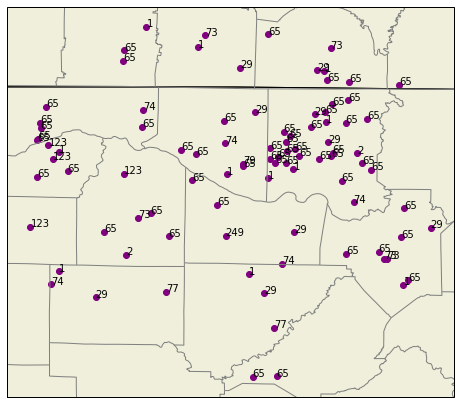

In [9]:
plt.figure(figsize=(8,8))
county_path = './counties/countyl010g.shp' #path to the county shapefile
ax = helpers.cartopyMap(county_path)

for s in st:
    ax.scatter(s.lon, s.lat, transform=ccrs.PlateCarree(), color='purple')
    plt.text(s.lon, s.lat, s.mnet)

#### Plot ASOS and CWOP station locations

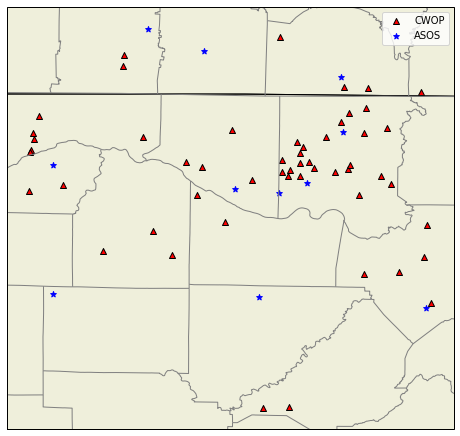

In [10]:
plt.figure(figsize=(8,8))
ax = helpers.cartopyMap(county_path)

# cwop data
cwop = [s for s in st if s.mnet == 65]
lons = [a.lon for a in cwop]
lats = [a.lat for a in cwop]
ax.scatter(lons, lats, facecolor='r', edgecolor='k', marker='^', transform=ccrs.PlateCarree(), label='CWOP')

# asos data
asos = [s for s in st if s.mnet == 1]
lons = [a.lon for a in asos]
lats = [a.lat for a in asos]
ax.scatter(lons, lats, c='b', marker='*', transform=ccrs.PlateCarree(), label='ASOS')
plt.legend()

#### Plot lines between CWOP stations and the nearest ASOS station

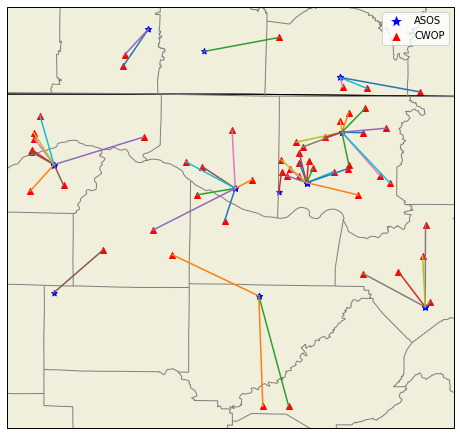

In [11]:
plt.figure(figsize=(8,8))
ax = helpers.cartopyMap(county_path)

nearest = [Station.toNearestStation(c, asos) for c in cwop]
#print([n.haversine for n in nearest])
for c in cwop:
    ax.scatter(c.lon, c.lat, marker='^', color='r')
for n in nearest:
    ax.scatter(n.lon, n.lat, marker='*', color='b')
for n in range(len(cwop)):
    ax.plot([cwop[n].lon, nearest[n].lon],[cwop[n].lat, nearest[n].lat])
legendElements = [Line2D([0], [0], marker='*', color='w', markerfacecolor='b', 
                         markersize=15, label='ASOS'),
                  Line2D([0], [0], marker='^', color='w', markerfacecolor='r', 
                         markersize=10, label='CWOP')]
ax.legend(handles=legendElements)
#plt.savefig('nearestCwopAsos_new.png', dpi=1000)

#### Plot all available temperatures

Text(0.5, 1.0, 'All Temperatures')

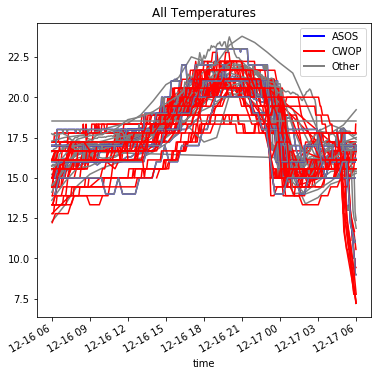

In [90]:
fig, ax = plt.subplots(figsize=(6,6))

for s in st:
    if s.mnet == 1:
        s.toDataFrame()['temp'].plot(ax=ax, color='b')
    if s.mnet == 65:
        s.toDataFrame()['temp'].plot(ax=ax, color='r')
    else:
        s.toDataFrame()['temp'].plot(ax=ax, color='gray')

# create a custom legend
custom_lines = [Line2D([0], [0], color='b', lw=2),
                Line2D([0], [0], color='r', lw=2),
                Line2D([0], [0], color='gray', lw=2)]
ax.legend(custom_lines, ['ASOS', 'CWOP', 'Other'])

plt.title('All Temperatures')

#### Plot all ASOS temperature data

Text(0.5, 1.0, 'ASOS Temperatures')

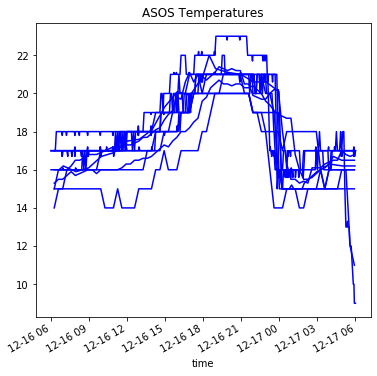

In [13]:
fig, ax = plt.subplots(figsize=(6,6))

for a in asos:
    a.toDataFrame()['temp'].plot(ax=ax, color='b')

plt.title('ASOS Temperatures')

#### Scatter and Histograms

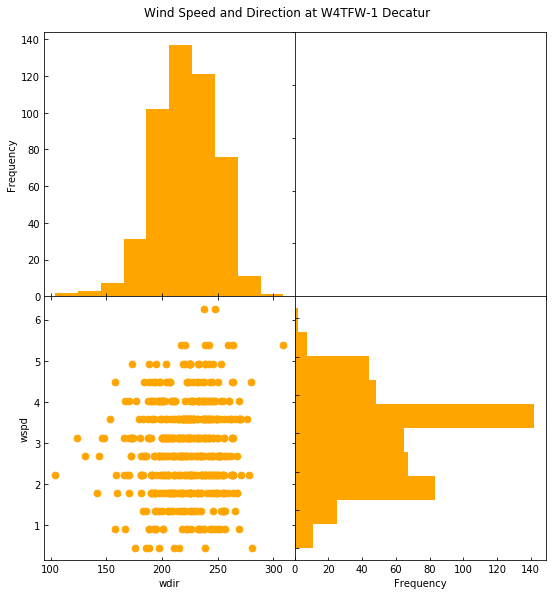

In [89]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9,9))

myStation = st[0]
df = myStation.toDataFrame()

df.plot.scatter(x='wdir', y='wspd', ax=ax[1,0], color='orange', s=45)
ax[1,0].tick_params(direction='in', top='True', right='True')

df['wspd'].plot.hist(ax=ax[1,1], color='orange', orientation='horizontal', sharey=True)
ax[1,1].tick_params(direction='in')

df['wdir'].plot.hist(ax=ax[0,0], color='orange', sharex=True)
ax[0,0].tick_params(direction='in')

plt.suptitle(f'Wind Speed and Direction at {myStation.name}')
fig.subplots_adjust(wspace=0,hspace=0,top=0.94)

#### Boxplot time series

Text(0.5, 1.0, 'All Temperatures, Boxplot Analysis')

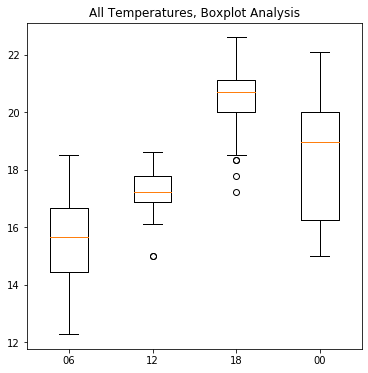

In [91]:
fig, ax = plt.subplots(figsize=(6,6))

dfs = [s.toDataFrame() for s in st]

temp_06 = np.array([helpers.getAtTime(d, '2019-12-16 06:00:00', 'temp') for d in dfs])
temp_06 = temp_06[~np.isnan(temp_06)]
temp_12 = np.array([helpers.getAtTime(d, '2019-12-16 12:00:00', 'temp') for d in dfs])
temp_12 = temp_12[~np.isnan(temp_12)]
temp_18 = np.array([helpers.getAtTime(d, '2019-12-16 18:00:00', 'temp') for d in dfs])
temp_18 = temp_18[~np.isnan(temp_18)]
temp_00 = np.array([helpers.getAtTime(d, '2019-12-17 00:00:00', 'temp') for d in dfs])
temp_00 = temp_00[~np.isnan(temp_00)]

boxplots = plt.boxplot([temp_06, temp_12, temp_18, temp_00], labels=['06','12','18','00'])

plt.title('All Temperatures, Boxplot Analysis')

## Working with multiple files

In [72]:
#load all station days
paths = glob('./data/*0600.json')
allStations = Station.loadMultipleJSON(paths)

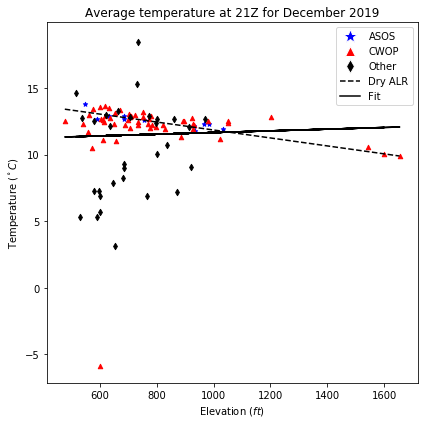

In [74]:
fig, ax = plt.subplots(figsize=(6,6))

#names, elevations, MNET IDs, average temperatures at 21Z
names = [s.name for s in allStations]
elevs = [s.elev for s in allStations]
mnets = [s.mnet for s in allStations]
avgTemps = [s.toDataFrame().resample('1H').nearest().at_time('21:00:00')['temp'].mean() for s in allStations]

#make a DataFrame to house all this data
df = pd.DataFrame(data={'name':names,'elev':elevs,'mnet':mnets,'avgT':avgTemps})
df = df.dropna()

#slicing the DataFrame by MNET ID
asos = df.loc[df['mnet'] == 1]
cwop = df.loc[df['mnet'] == 65]
other = df.loc[(df['mnet'] != 1) & (df['mnet'] != 65)]

#plotting
asos.plot(x='elev', y='avgT', ax=ax, kind='scatter', color='b', marker='*')
cwop.plot(x='elev', y='avgT', ax=ax, kind='scatter', color='r', marker='^')
other.plot(x='elev', y='avgT', ax=ax, kind='scatter', color='k', marker='d')

#plot a best fit line through the data
m, b = np.polyfit(df['elev'], df['avgT'], 1)
plt.plot(df['elev'], m*df['elev'] + b, 'k-')

#plot dry adiabatic lapse rate
dryALRhgts = np.arange(np.min(df['elev']), np.max(df['elev']), 2)
plt.plot(dryALRhgts, helpers.dryALR(dryALRhgts), 'k--')

#legend
legendElements = [Line2D([0], [0], marker='*', color='w', markerfacecolor='b', 
                 markersize=15, label='ASOS'),
                  Line2D([0], [0], marker='^', color='w', markerfacecolor='r',
                         markersize=10, label='CWOP'),
                 Line2D([0], [0], marker='d', color='w', markerfacecolor='k',
                 markersize=10, label='Other'),
                Line2D([0],[0], linestyle='--', color='k', label='Dry ALR'),
                Line2D([0],[0], linestyle='-', color='k', label='Fit')]
ax.legend(handles=legendElements)

plt.title('Average temperature at 21Z for December 2019')
plt.ylabel('Temperature ($^\circ C$)') #temperature
plt.xlabel('Elevation $(ft)$')
plt.tight_layout()

In [79]:
#value differences between average temps and the dry ALR model
errors = df['avgT'] - helpers.dryALR(df['elev'])
df['error'] = errors
print(df)

                     name  elev  mnet       avgT     error
0                AAMU/JTG   860    29  12.664516  0.392443
1                 ADDISON   766    77   6.871333 -5.681522
2          AL PWR CO GAGE   920    74   9.092667 -3.000185
3             ALLEN FARMS   705    29  12.822581  0.087516
4                ANDERSON   685    74   9.277333 -3.517472
..                    ...   ...   ...        ...       ...
91       W4ZZK-1 Leighton   560    65  12.975161 -0.193024
92      WA4BPS Huntsville  1601    65  10.054194 -0.004483
93            WATER PLANT   654    73   3.160690 -9.726714
94  WATER TREATMENT PLANT   680    74   8.279677 -4.530063
95                  WTARS   837    29  10.698710 -1.642066

[96 rows x 5 columns]
